In [251]:
import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import river
from river import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.lazy import SAMKNNClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from skmultiflow.data import DataStream
from skmultiflow.meta import OnlineRUSBoostClassifier
from skmultiflow.meta import AdaptiveRandomForestClassifier
from skmultiflow.meta import AccuracyWeightedEnsembleClassifier
from skmultiflow.drift_detection.adwin import ADWIN






In [252]:
inc_data = arff.load('INSECTS-incremental_balanced_norm.arff')
inc_df = pd.DataFrame(list(inc_data))

inc_df = inc_df.replace(['ae-aegypti-male'], 0)
inc_df = inc_df.replace(['cx-quinq-male'], 1)
inc_df = inc_df.replace(['cx-quinq-female'], 2)
inc_df = inc_df.replace(['ae-aegypti-female'], 3)
inc_df = inc_df.replace(['ae-albopictus-female'], 4)
inc_df = inc_df.replace(['ae-albopictus-male'], 5)

inc_X = inc_df.iloc[:, 0:-1].to_numpy()
inc_y = inc_df.iloc[:, -1].to_numpy()
# {'ae-aegypti-male', 'cx-quinq-male', 'cx-quinq-female', 'ae-aegypti-female', 'ae-albopictus-female', 'ae-albopictus-male'}
# a = set(y)
# print(a)-
print(inc_X.shape)
print(inc_y.shape)

inc_stream = DataStream(data=inc_X, y=inc_y)


(57018, 33)
(57018,)


In [253]:
inc_abr_data = arff.load('INSECTS-abrupt_balanced_norm.arff')
inc_abr_df = pd.DataFrame(list(inc_abr_data))

inc_abr_df = inc_abr_df.replace(['ae-aegypti-male'], 0)
inc_abr_df = inc_abr_df.replace(['cx-quinq-male'], 1)
inc_abr_df = inc_abr_df.replace(['cx-quinq-female'], 2)
inc_abr_df = inc_abr_df.replace(['ae-aegypti-female'], 3)
inc_abr_df = inc_abr_df.replace(['ae-albopictus-female'], 4)
inc_abr_df = inc_abr_df.replace(['ae-albopictus-male'], 5)

inc_abr_X = inc_abr_df.iloc[:, 0:-1].to_numpy()
inc_abr_y = inc_abr_df.iloc[:, -1].to_numpy()
# a = set(inc_abr_y)
# print(a)


# {'ae-aegypti-male', 'cx-quinq-male', 'cx-quinq-female', 'ae-aegypti-female', 'ae-albopictus-female', 'ae-albopictus-male'}

print(inc_abr_X.shape)
print(inc_abr_y.shape)

inc_abr_stream = DataStream(data=inc_abr_X, y=inc_abr_y)

(52848, 33)
(52848,)


In [254]:
inc_gra_data = arff.load('INSECTS-gradual_balanced_norm.arff')
inc_gra_df = pd.DataFrame(list(inc_gra_data))

inc_gra_df = inc_gra_df.replace(['ae-aegypti-male'], 0)
inc_gra_df = inc_gra_df.replace(['cx-quinq-male'], 1)
inc_gra_df = inc_gra_df.replace(['cx-quinq-female'], 2)
inc_gra_df = inc_gra_df.replace(['ae-aegypti-female'], 3)
inc_gra_df = inc_gra_df.replace(['ae-albopictus-female'], 4)
inc_gra_df = inc_gra_df.replace(['ae-albopictus-male'], 5)
# a = set(inc_gra_y)
# print(a)

inc_gra_X = inc_gra_df.iloc[:, 0:-1].to_numpy()
inc_gra_y = inc_gra_df.iloc[:, -1].to_numpy()

# {'ae-aegypti-male', 'cx-quinq-male', 'cx-quinq-female', 'ae-aegypti-female', 'ae-albopictus-female', 'ae-albopictus-male'}

print(inc_gra_X.shape)
print(inc_gra_y.shape)

inc_gra_stream = DataStream(data=inc_gra_X, y=inc_gra_y)

(24150, 33)
(24150,)


In [255]:
def no_change_classifier(X, y):
    # X is a numpy array of shape (n_samples, n_features)
    # y is a numpy array of shape (n_samples,)
    # returns a numpy array of shape (n_samples,)
    y_true = []
    y_pred = []
    last_seen = -1
    correct_cnt, n_samples = 0, 0
    acc_list = []
    for xi, yi in zip(X, y):
        y_pred.append(last_seen)
        y_true.append(yi)
        if(yi == last_seen):
            correct_cnt+=1
        last_seen = yi
        n_samples+=1
        if(n_samples % 1000 == 0):
            acc_list.append(accuracy_score(y_true[-1000:], y_pred[-1000:]))
    return acc_list


In [256]:
def majority_class_classifier(X, y):
    # X is a numpy array of shape (n_samples, n_features)
    # y is a numpy array of shape (n_samples,)
    # returns a numpy array of shape (n_samples,)
    left, right = 0, 0
    cnt = [0, 0, 0, 0, 0, 0]
    maxY = 0
    maxCnt = 0
    correct_cnt = 0
    y_true = []
    y_pred = []
    acc_list = []
    while(right < len(y)):
        y_true.append(y[right])
        y_pred.append(maxY)

        cnt[y[right]] += 1
        for i in range(6):
            if(cnt[i] > maxCnt):
                maxCnt = cnt[i]
                maxY = i
        right += 1
        if(right % 1000 == 0):
            acc_list.append(accuracy_score(y_true[-1000:], y_pred[-1000:]))
        if(right - left > 1000):
            cnt[y[left]] -= 1
            left += 1

    return acc_list
    




In [257]:
def train(data_stream, classifier):
    if not data_stream.has_more_samples():
        print('restart stream')
        data_stream.restart()
        
    acc_list = []
    n_samples = 1000
    X, y = data_stream.next_sample(1000)

    classifier.partial_fit(X, y)
    y_pred = classifier.predict(X)
    
    while data_stream.has_more_samples():
        single_X, single_y = data_stream.next_sample()
        y_pred = np.append(y_pred, classifier.predict(single_X))
        X = np.append(X, single_X, axis=0)
        y = np.append(y, single_y)
        # y.append(single_y)
        if(n_samples % 1000 == 0):
            acc_list.append(accuracy_score(y[-1000:], y_pred[-1000:]))
        classifier.partial_fit(single_X, single_y)
        n_samples += 1
    return acc_list


In [258]:
def train_with_drift_detetion(data_stream, classifier):
    adwin = ADWIN()
    ht = HoeffdingTreeClassifier()

    if not data_stream.has_more_samples():
        print('restart stream')
        data_stream.restart()

    dd_list = []    
    acc_list = []
    n_samples = 1000
    X, y = data_stream.next_sample(1000)

    classifier.partial_fit(X, y)
    y_pred = classifier.predict(X)

    for i in range(1000):
        adwin.add_element(int(y[i]))
        if adwin.detected_change():
            dd_list.append(i)

    detected = False
    while data_stream.has_more_samples():
        single_X, single_y = data_stream.next_sample()

        adwin.add_element(int(single_y))
        if adwin.detected_change():
            dd_list.append(n_samples)
            detected = True

        y_pred = np.append(y_pred, classifier.predict(single_X))
        X = np.append(X, single_X, axis=0)
        y = np.append(y, single_y)
        acc_list.append(accuracy_score(y[-1000:], y_pred[-1000:]))

        classifier.partial_fit(single_X, single_y)
        n_samples += 1

        if detected:
            classifier = ht.partial_fit(X[-1000:, :], y[-1000:])
            detected = False
    dd_list.append(n_samples)
    return acc_list, dd_list


In [259]:
ht = HoeffdingTreeClassifier()
knn = SAMKNNClassifier(n_neighbors=5)
hat = HoeffdingAdaptiveTreeClassifier()
awe = AccuracyWeightedEnsembleClassifier()
arf = AdaptiveRandomForestClassifier()

In [260]:
ht_inc_acc_list = train(inc_stream, ht)
knn_inc_acc_list = train(inc_stream, knn)
hat_inc_acc_list = train(inc_stream, hat)
awe_inc_acc_list = train(inc_stream, awe)
arf_inc_acc_list = train(inc_stream, arf)
no_change_inc_acc_list = no_change_classifier(inc_X, inc_y)
majority_class_inc_acc_list = majority_class_classifier(inc_X, inc_y)

restart stream
restart stream
restart stream
restart stream


In [ ]:
ht_inc_abr_acc_list = train(inc_abr_stream, ht)
knn_inc_abr_acc_list = train(inc_abr_stream, knn)
hat_inc_abr_acc_list = train(inc_abr_stream, hat)
awe_inc_abr_acc_list = train(inc_abr_stream, awe)
arf_inc_abr_acc_list = train(inc_abr_stream, arf)
no_change_inc_abr_acc_list = no_change_classifier(inc_abr_X, inc_abr_y)
majority_class_inc_abr_acc_list = majority_class_classifier(inc_abr_X, inc_abr_y)

In [ ]:
ht_inc_gra_acc_list = train(inc_gra_stream, ht)
knn_inc_gra_acc_list = train(inc_gra_stream, knn)
hat_inc_gra_acc_list = train(inc_gra_stream, hat)
awe_inc_gra_acc_list = train(inc_gra_stream, awe)
arf_inc_gra_acc_list = train(inc_gra_stream, arf)
no_change_inc_gra_acc_list = no_change_classifier(inc_gra_X, inc_gra_y)
majority_class_inc_gra_acc_list = majority_class_classifier(inc_gra_X, inc_gra_y)

In [ ]:
plt.title('INSECTS Incremental balanced norm')
plt.plot(ht_inc_acc_list, label='ht', linewidth=1)
plt.plot(knn_inc_acc_list, label='knn', linewidth=1)
plt.plot(hat_inc_acc_list, label='hat', linewidth=1)
plt.plot(awe_inc_acc_list, label='awe', linewidth=1)
plt.plot(arf_inc_acc_list, label='arf', linewidth=1)
plt.plot(no_change_inc_acc_list, label='no-change', linewidth=1)
plt.plot(majority_class_inc_acc_list, label='majority-class', linewidth=1)
plt.ylim(0, 1)
plt.xlabel('Time, instances')
plt.ylabel('Prequential Accuracy %')
plt.legend()
plt.show()




In [ ]:
plt.title('INSECTS Incremental abrupt norm')
plt.plot(ht_inc_abr_acc_list, label='ht', linewidth=1)
plt.plot(knn_inc_abr_acc_list, label='knn', linewidth=1)
plt.plot(hat_inc_abr_acc_list, label='hat', linewidth=1)
plt.plot(awe_inc_abr_acc_list, label='awe', linewidth=1)
plt.plot(arf_inc_abr_acc_list, label='arf', linewidth=1)
plt.plot(no_change_inc_abr_acc_list, label='no-change', linewidth=1)
plt.plot(majority_class_inc_abr_acc_list, label='majority-class', linewidth=1)
plt.ylim(0, 1)
plt.xlabel('Time, instances')
plt.ylabel('Prequential Accuracy %')
plt.legend()
plt.show()



In [ ]:
plt.title('INSECTS Incremental gradual norm')
plt.plot(ht_inc_gra_acc_list, label='ht', linewidth=1)
plt.plot(knn_inc_gra_acc_list, label='knn', linewidth=1)
plt.plot(hat_inc_gra_acc_list, label='hat', linewidth=1)
plt.plot(awe_inc_gra_acc_list, label='awe', linewidth=1)
plt.plot(arf_inc_gra_acc_list, label='arf', linewidth=1)
plt.plot(no_change_inc_gra_acc_list, label='no-change', linewidth=1)
plt.plot(majority_class_inc_gra_acc_list, label='majority-class', linewidth=1)
plt.ylim(0, 1)
plt.xlabel('Time, instances')
plt.ylabel('Prequential Accuracy %')
plt.legend()
plt.show()

In [249]:

# randome list with 100 elements from 0 to 1
# import random
# ht_inc_dd_acc_list = [random.random() for i in range(100)]
# # randome list with 10 elements from 0 to 100
# ht_inc_dd_list = [random.randint(0, 100) for i in range(10)]

ht_inc_dd_acc_list, ht_inc_dd_list = train_with_drift_detetion(inc_stream, ht)
# ht_inc_abr_dd_acc_list, ht_inc_abr_dd_list = train_with_drift_detetion(inc_abr_stream, ht)
# ht_inc_gra_dd_acc_list, ht_inc_gra_dd_list= train_with_drift_detetion(inc_gra_stream, ht)


restart stream


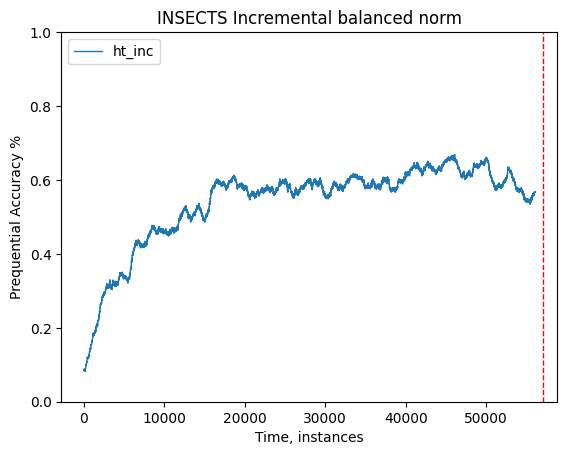

In [250]:
# print(ht_inc_dd_list)

plt.title('INSECTS Incremental balanced norm')
plt.plot(ht_inc_dd_acc_list, label='ht_inc', linewidth=1)
for d in ht_inc_dd_list:
    plt.axvline(x=d, color='r', linestyle='--', linewidth=1)
plt.ylim(0, 1)
plt.xlabel('Time, instances')
plt.ylabel('Prequential Accuracy %')
plt.legend()
plt.show()